In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
PATH = '/content/gdrive/MyDrive/Thesis/EthanolConcentration/'

In [3]:
import glob
import pandas as pd
import numpy as np


import tensorflow as tf
import keras
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, Conv2D, Conv1D, BatchNormalization, ELU, Reshape, concatenate, ReLU
from tensorflow.keras.layers import Dropout, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D, Permute


In [4]:
def add_missing_values(data, stride=1, sparcity = 0.02, fill_method = 'zero'):
    
    shape = data.shape
    size = shape[0]*shape[1]
    
    mask = np.zeros(size, dtype=int)
    mask[:int(size*sparcity/stride)] = 1
    np.random.shuffle(mask)
    
    mask = mask.reshape(shape)
    mask_orig = mask.copy()
    for step in range(1,stride):
        mask = mask + np.hstack((np.zeros((shape[0], step)), mask_orig[:, :-step]))
        
    mx = np.ma.masked_array(data, mask=mask)
    
    if fill_method == 'zero':
        mx = mx.filled(0)
    if fill_method == 'forw_fill':
        
        df = pd.DataFrame(mx)
        df.fillna(method='ffill', axis=1, inplace=True)
        df.fillna(method='bfill', axis=1, inplace=True)
        mx = df.to_numpy()
    if fill_method == 'mean':
        mx = mx.filled(np.mean(mx))
    
    return mx, mask

In [5]:
train = glob.glob(PATH + 'EthanolConcentrationDimension*_TRAIN.arff')
test = glob.glob(PATH + 'EthanolConcentrationDimension*_TEST.arff')

In [6]:
columns = [f't{t}' for t in range(1, 1751)]
columns.append('class')
train_data = [pd.read_csv(file, skiprows=1756, names=columns) for file in train]
test_data = [pd.read_csv(file, skiprows=1756, names=columns) for file in test]


In [7]:
train_data[0].head()

t1      t2      t3      t4      t5      t6      t7      t8  \
1724.8  1726.9  1726.8  1725.0  1725.7  1725.9  1724.0  1724.9  1728.9   
1763.6  1759.5  1759.9  1758.8  1757.7  1756.3  1754.5  1753.3  1754.4   
1775.3  1777.0  1778.2  1776.0  1773.0  1769.8  1770.0  1772.6  1771.8   
1747.8  1745.3  1745.0  1745.9  1746.5  1746.8  1748.0  1749.1  1749.5   
1742.1  1742.3  1743.7  1744.9  1745.1  1745.9  1747.0  1748.2  1748.8   

            t9     t10  ...   t1742   t1743   t1744   t1745   t1746   t1747  \
1724.8  1730.0  1728.6  ...  1889.5  1887.0  1883.2  1881.4  1874.3  1881.6   
1763.6  1758.4  1757.9  ...  2014.8  2012.8  2007.3  2012.8  2003.0  1994.9   
1775.3  1771.3  1773.3  ...  1932.7  1929.4  1931.3  1932.6  1928.2  1923.6   
1747.8  1748.7  1744.0  ...  1988.5  1982.9  1978.5  1972.7  1971.8  1971.4   
1742.1  1744.9  1741.7  ...  2048.5  2038.9  2037.5  2032.5  2033.3  2024.0   

         t1748   t1749   t1750  class  
1724.8  1877.9  1872.3  1870.3    E35  
1763.6  1996.9  1997.6  1995.2    E35  
1775.3  1922.0  1921.6  1917.6    E35  
1747.8  1969.9  1969.0  1966.1    E35  
1742.1  2020.0  2021.9  2015.8    E35  

[5 rows x 1751 columns]

In [8]:
def code_to_ranks(labels):
    labels = list(set(labels))
    labels.sort()
    
    encoding = {key: value for value, key in enumerate(labels)}
    
    return encoding

def standard_scaling(data_3dim):
    #Observations, attributes, TS  length
    scaled = (data_3dim - np.mean(data_3dim, axis=2, keepdims=True)) /  \
                                np.std(data_3dim, axis=2, keepdims=True)
    
    return scaled


train = np.stack(train_data, axis=2)
train = np.swapaxes(train, 1,2)
train_labels = train[:,1,-1]
train = train[:,:,:-1]
train = train.astype(float)
train = standard_scaling(train)

nans = [np.sum(np.isnan(train[i, :, :])) for i in range(train.shape[0])] 
nans_idx = [idx for idx, value in enumerate(nans) if value !=0]
train = np.delete(train, nans_idx, axis=0)

train_with_miss = [add_missing_values(obs, fill_method='zero', sparcity = 0.1) for obs in train]
train_with_miss_no_ind = [np.stack((v)) for v, m in train_with_miss]
train_with_miss = [np.transpose(np.stack((v, m)), axes=(1,2,0)) for v, m in train_with_miss]


train_with_miss = np.array(train_with_miss)
train_with_miss_no_ind = np.array(train_with_miss_no_ind)




enc = code_to_ranks(train_labels)
train_labels = np.array([enc[l] for l in train_labels]).reshape(-1,1)
train_labels = train_labels.astype(int)
train_labels = np.delete(train_labels, nans_idx, axis=0)

test = np.stack(test_data, axis=2)
test = np.swapaxes(test, 1,2)
test_labels = test[:,1,-1]
test_labels = np.array([enc[l] for l in test_labels]).reshape(-1,1)
test_labels= test_labels.astype(int)
test = test[:,:,:-1]
test = test.astype(float)
test = standard_scaling(test)

nans = [np.sum(np.isnan(test[i, :, :])) for i in range(test.shape[0])] 
nans_idx = [idx for idx, value in enumerate(nans) if value !=0]
test = np.delete(test, nans_idx, axis=0)
test_labels = np.delete(test_labels, nans_idx, axis=0)

test_with_miss = [add_missing_values(obs, fill_method='zero', sparcity = 0.01) for obs in test]
test_with_miss_no_ind = [np.stack((v)) for v, m in test_with_miss]
test_with_miss = [np.transpose(np.stack((v, m)), axes=(1,2,0)) for v, m in test_with_miss]

test_with_miss = np.array(test_with_miss) 

test_with_miss_no_ind = np.array(test_with_miss_no_ind)


In [9]:
pd.DataFrame(data=train[100,:,:].T).describe()

0             1             2
count  1.750000e+03  1.750000e+03  1.750000e+03
mean   2.596526e-15  2.042937e-15  2.610610e-15
std    1.000286e+00  1.000286e+00  1.000286e+00
min   -9.063946e-01 -9.816051e-01 -9.380613e-01
25%   -8.691286e-01 -9.316633e-01 -8.971021e-01
50%   -4.854313e-01 -3.522387e-01 -4.550524e-01
75%    9.112766e-01  9.556202e-01  1.020411e+00
max    2.017308e+00  1.868406e+00  1.830706e+00

In [16]:

def lsst_model(input_shape, num_classes):
    
    X_input = Input(shape=input_shape)

 	# Temporal Convolutions
    conv1 = Conv2D(64, (1, 1), strides=1, padding="same", kernel_initializer='he_uniform')(X_input)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU(alpha=1.0)(conv1)
    # conv1 = ReLU()(conv1)
    conv1 = Permute((3,2,1))(conv1)

    conv1 = Conv2D(32, (1, 5), strides=1, padding="same", kernel_initializer='he_uniform')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU(alpha=1.0)(conv1)
    # conv1 = ReLU()(conv1)
    conv1 = Permute((3,2,1))(conv1)
    
    conv2 = Conv2D(64, (1, 6), strides=1, padding="same", kernel_initializer='he_uniform')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU(alpha=1.0)(conv2)
    # conv2 = ReLU()(conv2)
    conv2 = Permute((3,2,1))(conv2)
    
    conv2 = Conv2D(32, (1, 5), strides=1, padding="same", kernel_initializer='he_uniform')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU(alpha=1.0)(conv2)
    # conv2 = ReLU()(conv2)
    conv2 = Permute((3,2,1))(conv2)

    conv3 = Conv2D(64, (1, 6), strides=1, padding="same", kernel_initializer='he_uniform')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU(alpha=1.0)(conv3)
    # conv3 = ReLU()(conv3)
    conv3 = Permute((3,2,1))(conv3)
    
    conv3 = Conv2D(32, (1, 5), strides=1, padding="same", kernel_initializer='he_uniform')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU(alpha=1.0)(conv3)
    # conv3 = ReLU()(conv3)

    conv4 = Conv2D(32, (1, 6), strides=1, padding="same", kernel_initializer='he_uniform')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU(alpha=1.0)(conv4)
    # conv4 = ReLU()(conv4)
    conv4 = Permute((3,2,1))(conv4)
    
    conv4 = Conv2D(16, (1, 5), strides=1, padding="same", kernel_initializer='he_uniform')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU(alpha=1.0)(conv4)
    # conv4 = ReLU()(conv4)


    conv5 = Conv2D(64, (1, 6), strides=1, padding="same", kernel_initializer='he_uniform')(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU(alpha=1.0)(conv5)
    # conv5 = ReLU()(conv5)
    conv5 = Permute((3,2,1))(conv5)
    
    conv5 = Conv2D(32, (1, 5), strides=1, padding="same", kernel_initializer='he_uniform')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU(alpha=1.0)(conv5)
    # conv5 = ReLU()(conv5)
    
  


    
    
    # MaxPool = MaxPooling2D(pool_size=(5, 1), strides=None, padding='same')(conv4)
    # conv4 = Dropout(0.4)(conv4)
    gap_DCNN = GlobalAveragePooling2D()(conv5)
    gap_DCNN = Dropout(0.1)(gap_DCNN)
    
    output_layer = tf.keras.layers.Dense(num_classes)(gap_DCNN)
    model = tf.keras.models.Model(inputs=X_input, outputs=output_layer)
    
    
    return model
    
    
m = lsst_model((3,1750,2), 4)
m.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3, 1750, 2)]      0         
                                                                 
 conv2d_48 (Conv2D)          (None, 3, 1750, 64)       192       
                                                                 
 batch_normalization_48 (Bat  (None, 3, 1750, 64)      256       
 chNormalization)                                                
                                                                 
 elu_48 (ELU)                (None, 3, 1750, 64)       0         
                                                                 
 permute_36 (Permute)        (None, 64, 1750, 3)       0         
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 1750, 32)      512       
                                                           

Epoch 1/500
23/23 [==============================] - 24s 971ms/step - loss: 1.4141 - accuracy: 0.2308 - val_loss: 2.7339 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/500
23/23 [==============================] - 22s 954ms/step - loss: 1.3888 - accuracy: 0.2624 - val_loss: 4.3303 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/500
23/23 [==============================] - 22s 952ms/step - loss: 1.3826 - accuracy: 0.2398 - val_loss: 9.0219 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 4/500
23/23 [==============================] - 22s 953ms/step - loss: 1.3736 - accuracy: 0.3032 - val_loss: 4.2877 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 5/500
23/23 [==============================] - 22s 952ms/step - loss: 1.3718 - accuracy: 0.2896 - val_loss: 1.7867 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 6/500
23/23 [==============================] - 22s 952ms/step - loss: 1.3621 - accuracy: 0.3213 - val_loss: 1.6218 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 7/500
23/23 [==============================] - 22s 9

[1.7512935400009155, 0.258555144071579]

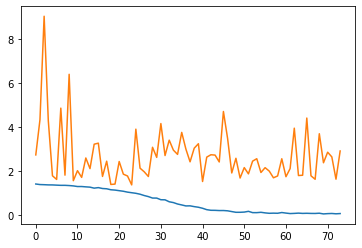

In [17]:
tf.debugging.set_log_device_placement(True)

X_train, X_val, y_train, y_val = train_test_split(train_with_miss, train_labels, test_size=0.15, random_state=147)


# model = lsst_model(input_shape = (3,1750,1), num_classes = 4)
model = lsst_model(input_shape = (3,1750,2), num_classes = 4)



loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)

model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001),
              loss=loss,
              metrics=['accuracy']
              )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=20, min_lr=0.0001)

loss_hist = model.fit(X_train, y_train, epochs=500,
                       batch_size=10,
                       validation_data=(X_val, y_val),
                       callbacks=[reduce_lr,
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                mode='auto',
                                                verbose=0,
                                                patience=75,
                                                restore_best_weights=True)
                                  ]
                       )


import matplotlib.pyplot as plt

plt.plot(loss_hist.history['loss'])
plt.plot(loss_hist.history['val_loss'])


model.evaluate(test_with_miss,  test_labels, verbose=2)

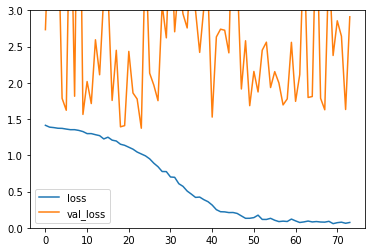

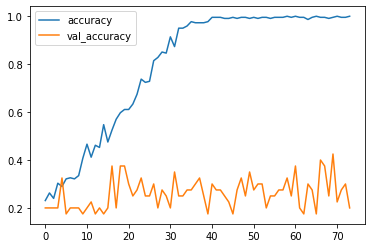

In [18]:

plt.plot(loss_hist.history['loss'], label = 'loss')
plt.plot(loss_hist.history['val_loss'], label  = 'val_loss')
plt.ylim((0,3))
plt.legend()
plt.show()



plt.plot(loss_hist.history['accuracy'], label = 'accuracy')
plt.plot(loss_hist.history['val_accuracy'], label  = 'val_accuracy')
plt.legend()
plt.show()




In [ ]:
tf.config.list_physical_devices()

In [ ]:
model.save((PATH + 'model1'))